In [1]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

## Homework

### Dataset

In this homework, we will use the California Housing Prices from [Kaggle](https://www.kaggle.com/datasets/camnugent/california-housing-prices).

Here's a wget-able [link](https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv):

```bash
wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv
```

The goal of this homework is to create a regression model for predicting housing prices (column `'median_house_value'`).

In [2]:
if not os.path.isfile('housing.csv'):
    !wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv

### EDA

* Load the data.
* Look at the `median_house_value` variable. Does it have a long tail? 

In [3]:
raw = pd.read_csv('housing.csv')
raw.head(5)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


<AxesSubplot:xlabel='median_house_value', ylabel='Count'>

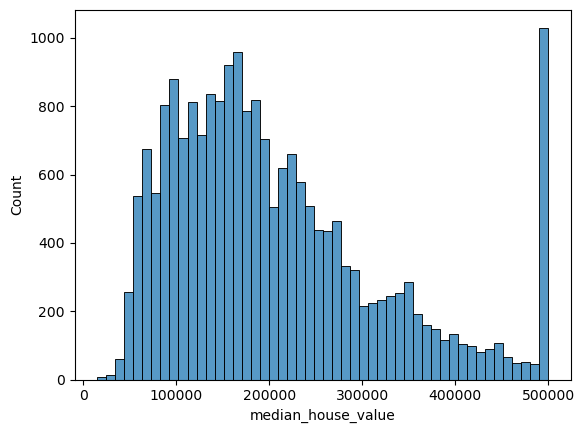

In [4]:
sns.histplot(raw.median_house_value, bins=50)

Yes it does look like the `median_house_value` has a long tail, possibly truncated at 500,000

### Features

For the rest of the homework, you'll need to use only these columns:

* `'latitude'`,
* `'longitude'`,
* `'housing_median_age'`,
* `'total_rooms'`,
* `'total_bedrooms'`,
* `'population'`,
* `'households'`,
* `'median_income'`,
* `'median_house_value'`

Select only them.

In [5]:
cols = [
    'latitude',
    'longitude',
    'housing_median_age',
    'total_rooms',
    'total_bedrooms',
    'population',
    'households',
    'median_income',
    'median_house_value'   
]

df = raw[cols]

### Question 1

Find a feature with missing values. How many missing values does it have?
- 207
- 307
- 408
- 508

In [6]:
df.apply(lambda x: sum(pd.isna(x)), axis = 0)

latitude                0
longitude               0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
dtype: int64

207 missing values in `total_bedrooms`

### Question 2

What's the median (50% percentile) for variable 'population'?
- 1133
- 1122
- 1166
- 1188

In [7]:
df.population.median()

1166.0

### Split the data

* Shuffle the initial dataset, use seed `42`.
* Split your data in train/val/test sets, with 60%/20%/20% distribution.
* Make sure that the target value ('median_house_value') is not in your dataframe.
* Apply the log transformation to the median_house_value variable using the `np.log1p()` function.

In [8]:
n = df.shape[0]
np.random.seed(42)
idx = np.arange(n)
np.random.shuffle(idx)

In [9]:
n_val = int(n * 0.2)
n_test = int(n * 0.2)
n_train = n - n_val - n_test

idx_train = idx[range(n_train)]
idx_val = idx[range(n_train, n_train + n_val)]
idx_test = idx[range(n_train + n_val, n)]

In [10]:
[n_train, n_val, n_test] == [len(idx) for idx in [idx_train, idx_val, idx_test]]

True

In [11]:
train = df.iloc[idx_train]
val = df.iloc[idx_val]
test = df.iloc[idx_test]

In [12]:
partitions = [train, val, test]

train_target, val_target, test_target = [
    np.log1p(dat.median_house_value) for dat in [train, val, test]
]

### Question 3

* We need to deal with missing values for the column from Q1.
* We have two options: fill it with 0 or with the mean of this variable.
* Try both options. For each, train a linear regression model without regularization using the code from the lessons.
* For computing the mean, use the training only!
* Use the validation dataset to evaluate the models and compare the RMSE of each option.
* Round the RMSE scores to 2 decimal digits using `round(score, 2)`
* Which option gives better RMSE?

Options:
- With 0
- With mean
- With median
- Both are equally good

In [13]:
pd.set_option('mode.chained_assignment', None)

partitions_zero_fill = []
partitions_mean_fill = []

mean_total_bedrooms = train.total_bedrooms.mean()

for p in partitions:
    pzf = p.copy()
    pmf = p.copy()

    pzf.total_bedrooms = pzf.total_bedrooms.fillna(0)
    pmf.total_bedrooms = pmf.total_bedrooms.fillna(mean_total_bedrooms)
    
    pzf = pzf.drop('median_house_value', axis=1)
    pmf = pmf.drop('median_house_value', axis=1)
    
    partitions_zero_fill.append(pzf)
    partitions_mean_fill.append(pmf)
    
train_X_zero_fill, val_X_zero_fill, test_X_zero_fills = partitions_zero_fill
train_X_mean_fill, val_X_mean_fill, test_X_mean_fills = partitions_mean_fill

In [14]:
def train_linear_regression(X, y):
    ones = np.ones(X.shape[0])
    
    X = np.column_stack([ones, X])
    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w_full = XTX_inv.dot(X.T).dot(y)

    return w_full[0], w_full[1:]

def rmse(y, y_pred):
    se = (y - y_pred) ** 2
    mse = se.mean()
    return np.sqrt(mse)

w0_zero_fill, w_zero_fill = train_linear_regression(train_X_zero_fill, train_target)
w0_mean_fill, w_mean_fill = train_linear_regression(train_X_mean_fill, train_target)

y_pred_zero_fill = w0_zero_fill + val_X_zero_fill.dot(w_zero_fill)
y_pred_mean_fill = w0_mean_fill + val_X_mean_fill.dot(w_mean_fill)

rmse_zero = rmse(val_target, y_pred_zero_fill)
rmse_mean = rmse(val_target, y_pred_mean_fill)

In [15]:
print(f'''
RMSE for zero-filled model: {round(rmse_zero, 2)}
RMSE for mean-filled model: {round(rmse_mean, 2)}
''')


RMSE for zero-filled model: 0.33
RMSE for mean-filled model: 0.33



In [16]:
print(f'''
RMSE for zero-filled model: {round(rmse_zero, 7)}
RMSE for mean-filled model: {round(rmse_mean, 7)}
''')


RMSE for zero-filled model: 0.329533
RMSE for mean-filled model: 0.3290195



### Question 4

* Now let's train a regularized linear regression.
* For this question, fill the NAs with 0. 
* Try different values of `r` from this list: `[0, 0.000001, 0.0001, 0.001, 0.01, 0.1, 1, 5, 10]`.
* Use RMSE to evaluate the model on the validation dataset.
* Round the RMSE scores to 2 decimal digits.
* Which `r` gives the best RMSE?

If there are multiple options, select the smallest `r`.

Options:
- 0
- 0.000001
- 0.001
- 0.0001

In [19]:
def train_linear_regression_reg(X, y, r=0.001):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX = XTX + r * np.eye(XTX.shape[0])

    XTX_inv = np.linalg.inv(XTX)
    w_full = XTX_inv.dot(X.T).dot(y)
   
    return w_full[0], w_full[1:]

r_values = [0, 0.000001, 0.0001, 0.001, 0.01, 0.1, 1, 5, 10]
r_rmses = []
for r_val in r_values:
    w0, w = train_linear_regression_reg(train_X_zero_fill, train_target, r=r_val) 
    preds = w0 + val_X_zero_fill.dot(w)
    r_rmse = rmse(val_target, preds)
    r_rmses.append(r_rmse)
    
r_val_df = pd.DataFrame({'r': r_values, 'rmse': r_rmses})
r_val_df['rounded_rmses'] = round(r_val_df.rmse, 2)

print(r_val_df)

           r      rmse  rounded_rmses
0   0.000000  0.329533           0.33
1   0.000001  0.329533           0.33
2   0.000100  0.329533           0.33
3   0.001000  0.329533           0.33
4   0.010000  0.329532           0.33
5   0.100000  0.329695           0.33
6   1.000000  0.333789           0.33
7   5.000000  0.339249           0.34
8  10.000000  0.340606           0.34


In [20]:
r_val_df.loc[r_val_df.rmse == r_val_df.rmse.min(), :]

,r,rmse,rounded_rmses
4,0.01,0.329532,0.33


### Question 5 

* We used seed 42 for splitting the data. Let's find out how selecting the seed influences our score.
* Try different seed values: `[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]`.
* For each seed, do the train/validation/test split with 60%/20%/20% distribution.
* Fill the missing values with 0 and train a model without regularization.
* For each seed, evaluate the model on the validation dataset and collect the RMSE scores. 
* What's the standard deviation of all the scores? To compute the standard deviation, use `np.std`.
* Round the result to 3 decimal digits (`round(std, 3)`)

> Note: Standard deviation shows how different the values are.
> If it's low, then all values are approximately the same.
> If it's high, the values are different. 
> If standard deviation of scores is low, then our model is *stable*.

Options:
- 0.16
- 0.00005
- 0.005
- 0.15555

In [26]:
seeds = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
seed_map = {seed:{} for seed in seeds}

df_seeds = df.copy()
df_seeds.total_bedrooms = df.total_bedrooms.fillna(0)
n = df_seeds.shape[0]


for seed in seeds:
    np.random.seed(seed)
    idx = np.arange(n)
    np.random.shuffle(idx)
       
    n_val = int(n * 0.2)
    n_test = int(n * 0.2)
    n_train = n - n_val - n_test

    idx_train = idx[range(n_train)]
    idx_val = idx[range(n_train, n_train + n_val)]
    idx_test = idx[range(n_train + n_val, n)]
    
    train = df_seeds.iloc[idx_train]
    val = df_seeds.iloc[idx_val]
    test = df_seeds.iloc[idx_test]
    
    train_target = np.log1p(train.median_house_value)
    val_target = np.log1p(val.median_house_value)
    
    train_X = train.drop('median_house_value', axis=1)
    val_X = val.drop('median_house_value', axis=1)

    w0, w = train_linear_regression(train_X, train_target)
    
    preds = w0 + val_X.dot(w)
    seed_map[seed]['rmse'] = rmse(val_target, preds)

rmses = [d['rmse'] for d in seed_map.values()]
std_dev = np.std(rmses)

print(f'Standard deviation of validation RMSE is {round(std_dev, 3)}')

Standard deviation of validation RMSE is 0.004


### Question 6

* Split the dataset like previously, use seed 9.
* Combine train and validation datasets.
* Fill the missing values with 0 and train a model with `r=0.001`. 
* What's the RMSE on the test dataset?

Options:
- 0.35
- 0.135
- 0.450
- 0.245

In [47]:
np.random.seed(9)
idx = np.arange(n)
np.random.shuffle(idx)

n_val = int(n * 0.2)
n_test = int(n * 0.2)
n_train = n - n_val - n_test

idx_train = idx[range(n_train)]
idx_val = idx[range(n_train, n_train + n_val)]
idx_test = idx[range(n_train + n_val, n)]

df_q9 = df.copy()

train = df_q9.iloc[idx_train]
val = df_q9.iloc[idx_val]
test = df_q9.iloc[idx_test]

new_train = pd.concat([train, val])
new_train.total_bedrooms = new_train.total_bedrooms.fillna(0)

new_train_X = new_train.drop('median_house_value', axis=1)
test_X = test.drop('median_house_value', axis=1)

new_train_target = np.log1p(new_train.median_house_value)
test_target = np.log1p(test.median_house_value)

w0, w = train_linear_regression_reg(new_train_X, new_train_target, r=0.001)
preds = w0 + test_X.dot(w)

rmse_q9 = rmse(preds, test_target)

print(f'RMSE for Q9 (seed 9, train+val combined, reg = 0.001) is {round(rmse_q9, 3)}')

RMSE for Q9 (seed 9, train+val combined, reg = 0.001) is 0.345


## Submit the results
- Submit your results here: https://forms.gle/WCVb4KMNsgbkuJtr6
- If your answer doesn't match options exactly, select the closest one.
- You can submit your solution multiple times. In this case, only the last submission will be used

## Deadline

The deadline for submitting is, 19 September 2022, 23:00 CET. After that, the form will be closed.